#### 9.7.1.2 Truncating Time Steps


##### Tổng quan về Truncated Backpropagation Through Time
Truncated Backpropagation Through Time (TBPTT) là một phương pháp tối ưu hóa quá trình huấn luyện các mạng nơ-ron hồi tiếp (RNN) trên các chuỗi dữ liệu dài, bằng cách chia chuỗi đầu vào thành các đoạn con (subsequences) có độ dài cố định.

##### Nguyên lý hoạt động
- Forward pass:
    - Mỗi đoạn con được xử lý tuần tự. Trạng thái ẩn (hidden state) từ đoạn con trước được truyền sang làm giá trị khởi tạo cho đoạn con tiếp theo.
    - Ví dụ: Nếu chuỗi gốc dài 100 bước thời gian được chia thành 4 đoạn (mỗi đoạn 25 bước), hidden state ở bước 25 sẽ dùng làm đầu vào cho đoạn 26–50.
- Backward pass:
    - Gradient chỉ được tính toán trong phạm vi từng đoạn con và bị "cắt bỏ" (truncated) khi chuyển sang đoạn tiếp theo.
    - Khác với BPTT tiêu chuẩn (gradient lan truyền qua toàn bộ chuỗi), TBPTT ngăn gradient từ đoạn sau ảnh hưởng đến đoạn trước nếu vượt quá độ dài đoạn con.

##### Ưu điểm của phương pháp trên:
1. Giảm nguy cơ gradient vanishing/exploding:
    - Việc giới hạn số bước $\tau$ làm giảm số lượng tích các ma trận Jacobian $\prod_{j=i+1}^t \frac{\partial f}{\partial h_{j-1}}$, từ đó:
        - Tránh tích luỹ các giá trị Jacobian nhỏ (< 1) gây gradient vanishing 
2. Tiết kiệm bộ nhớ
    - Chỉ lưu trữ gradient cho $\tau$ bước gần nhất, giảm đáng kể yêu cầu bộ nhớ
3. Tốc độ
    - Giảm chi phí tính toán cho chuỗi dài khi số phép tính giảm từ O($T$) xuống còn O($\tau$)

##### Hạn chế:
- Việc giới hạn số bước khiến cho các phụ thuộc từ đầu chuỗi không được xét đến, dẫn đến giảm hiệu suất trong các tác vụ yêu cầu bộ nhớ dài
- Gradient tính toán không chính xác như Full Computation, nhưng vẫn đủ tốt để huấn luyện hiệu quả

##### Ứng dụng thực tế:
- Mô hình ngôn ngữ (Language Models): xử lý văn bản dài
- Dự báo chuỗi thời gian: Dự báo giá cổ phiếu, thời tiết
- Xử lý âm thanh: Nhận dạng giọng nói

##### Hiện thực:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import psutil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- **Trong đó**: 
    - `numpy`: Tạo dữ liệu sóng sine.
    - `torch`: Xây dựng và huấn luyện RNN.
    - `matplotlib`: Vẽ biểu đồ loss.
    - `time`, `psutil`: Đo thời gian và bộ nhớ.
    - `device`: Sử dụng GPU nếu có, nếu không dùng CPU.

Ta sẽ tạo một chuỗi sóng sine với nhiễu Gaussian để huấn luyện mô hình

In [2]:
def generate_data(seq_length=10000):
    t = np.linspace(0, 100, seq_length)
    y = np.sin(t) + 0.1 * np.random.randn(seq_length) 
    return y

- **Tham số**:
  - `seq_length=10000`: Độ dài chuỗi.
  - `t`: Chuỗi thời gian từ 0 đến 100.
  - `y`: Sóng sine với nhiễu (độ lệch chuẩn 0.1).
- **Mục đích**: Tạo dữ liệu mô phỏng chuỗi thời gian thực tế.

Tiếp theo, ta xây dựng mô hình RNN đơn giản sử dụng nn.Module của PyTorch với một hidden layer và một linear layer để dự đoán: 

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        out = self.fc(out)
        return out, h 

- **Cấu trúc**:
  - `input_size=1`: Mỗi bước thời gian nhận một giá trị.
  - `hidden_size=32`: Kích thước lớp ẩn.
  - `batch_first=True`: Đầu vào có dạng (batch_size, seq_length, input_size).
  - `fc`: Lớp tuyến tính ánh xạ từ lớp ẩn sang đầu ra.
- **Hàm forward**: Trả về dự đoán và trạng thái ẩn.

Để huấn luyện mô hình, ta định nghĩa Hàm `train` hỗ trợ cả Full BPTT và Truncated BPTT, đồng thời đo lường thời gian và bộ nhớ.

In [4]:
def train(model, data, truncate_length=200, num_epochs=30, lr=0.01, is_truncate=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    model.train()

    # Đo thời gian bắt đầu
    start_time = time.time()

    # Đo bộ nhớ ban đầu
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024  # MB

    # Đo bộ nhớ GPU ban đầu
    if torch.cuda.is_available():
        gpu_mem_before = torch.cuda.memory_allocated() / 1024 ** 2  # MB
        gpu_reserved_before = torch.cuda.memory_reserved() / 1024 ** 2  # MB
    else:
        gpu_mem_before = 0.0
        gpu_reserved_before = 0.0

    seq_len = len(data)-1
    data = np.array(data)

    if is_truncate:
        # Truncated BPTT
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
        for epoch in range(num_epochs):
            h = None
            total_loss = 0
            num_steps = 0
            optimizer.zero_grad()

            for start in range(0, seq_len, truncate_length):
                end = min(start + truncate_length, seq_len)
                segment_length = end - start

                x = data_tensor[start:end].view(1, segment_length, 1)
                y_true = data_tensor[start+1:end+1].view(1, segment_length, 1)

                y_pred, h = model(x, h)
                loss = criterion(y_pred, y_true)
                loss.backward()
                total_loss += loss.item() * segment_length
                num_steps += segment_length
                h = h.detach()

            optimizer.step()
            avg_loss = total_loss / num_steps
            losses.append(avg_loss)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")
    else:
        # Full BPTT
        x = torch.tensor(data[:-1], dtype=torch.float32).view(1, seq_len, 1).to(device)
        y_true = torch.tensor(data[1:], dtype=torch.float32).view(1, seq_len, 1).to(device)

        for epoch in range(num_epochs):
            model.zero_grad()
            y_pred, _ = model(x)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}")

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Đo bộ nhớ GPU sau huấn luyện
    if torch.cuda.is_available():
        gpu_mem_after = torch.cuda.memory_allocated() / 1024 ** 2  # MB
        gpu_reserved_after = torch.cuda.memory_reserved() / 1024 ** 2  # MB
    else:
        gpu_mem_after = 0.0
        gpu_reserved_after = 0.0

    # Tính bộ nhớ GPU sử dụng
    gpu_mem_used = gpu_mem_after - gpu_mem_before
    gpu_reserved_used = gpu_reserved_after - gpu_reserved_before

    # Đo bộ nhớ sau huấn luyện
    mem_after = process.memory_info().rss / 1024 / 1024  # MB
    mem_used = mem_after - mem_before

    return losses, elapsed_time, mem_used, gpu_mem_used, gpu_reserved_used

- **Tham số**:
  - `truncate_length=200`: Độ dài đoạn cho Truncated BPTT.
  - `num_epochs=30`: Số epoch huấn luyện.
  - `lr=0.01`: Tốc độ học.
  - `is_truncate`: Chọn giữa Truncated BPTT (`True`) và Full BPTT (`False`).
- **Đo lường**:
  - Thời gian huấn luyện (giây).
  - Bộ nhớ CPU và GPU sử dụng (MB).
- **Trả về**: Danh sách loss, thời gian, bộ nhớ CPU/GPU sử dụng.

Sau khi định nghĩa xong các lớp và hàm cần thiết, ta tiến hành huấn luyện hai mô hình: một với Truncated BPTT (độ dài truncate 200) và một với Full BPTT.

In [5]:
data = generate_data()
# Huấn luyện với truncated BPTT
print("Fix Truncate BPTT")
model_truncated = RNN().to(device)
losses_truncated, time_truncated, memory_truncated, gpu_mem_truncated, gpu_reserved_truncated = train(model_truncated, data)

# Huấn luyện với full BPTT
print("Full BPTT")
model_standard = RNN().to(device)
losses_standard, time_standard, memory_standard, gpu_mem_standard, gpu_reserved_standard = train(model_standard, data, is_truncate=False)

Fix Truncate BPTT
Epoch 5/30, Loss: 0.030703
Epoch 10/30, Loss: 0.078559
Epoch 15/30, Loss: 0.045523
Epoch 20/30, Loss: 0.029028
Epoch 25/30, Loss: 0.015855
Epoch 30/30, Loss: 0.014005
Full BPTT
Epoch 5/30, Loss: 0.238577
Epoch 10/30, Loss: 0.092162
Epoch 15/30, Loss: 0.019071
Epoch 20/30, Loss: 0.014913
Epoch 25/30, Loss: 0.023099
Epoch 30/30, Loss: 0.015855


`Biểu đồ loss` được vẽ để so sánh tốc độ hội tụ của hai phương pháp

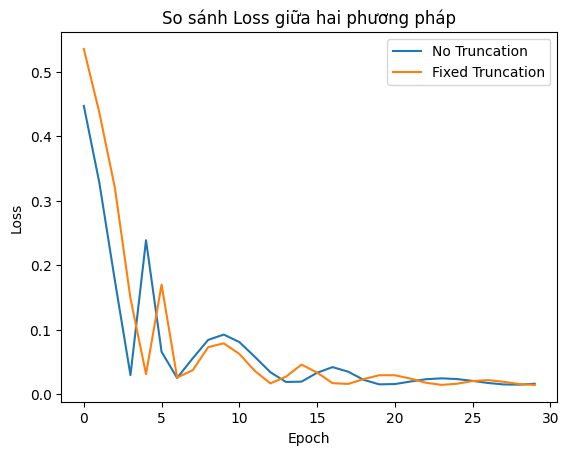

In [6]:
plt.plot(losses_standard, label="No Truncation")
plt.plot(losses_truncated, label="Fixed Truncation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("So sánh Loss giữa hai phương pháp")
plt.show()

- **Mô tả**:
    - Phương pháp Full BPTT được thể hiện bằng đường màu xanh. Ban đầu, hàm mất mát khởi tạo ở mức cao nhưng giảm nhanh và hội tụ ổn định theo thời gian. Có thể thấy sự dao động giữa các epoch là lớn do phải xử lý chuỗi dài không giới hạn, dẫn đến việc tính toán gradient thiếu ổn định.
    - Phương pháp Truncated BPTT được thể hiện bằng đường màu cam. Ban đầu hàm mất mát có xu hướng giảm nhanh hơn phương pháp Full BPTT nhưng ổn định sớm hơn nhờ vào sự giảm thiểu đáng kể biến động gradient.


Kết quả về thời gian và bộ nhớ được in ra để so sánh.

In [8]:
print("\n==== Kết Quả ====")
print(f"[No Truncation]    Thời gian: {time_standard:.2f} giây, Bộ nhớ tăng (CPU): {memory_standard:.2f} MB")
print(f"[Fix Truncation] Thời gian: {time_truncated:.2f} giây, Bộ nhớ tăng (CPU): {memory_truncated:.2f} MB")

if torch.cuda.is_available():
    print("\n==== Thống kê GPU (kèm thời gian huấn luyện) ====")
    print(f"[No Truncation]    Thời gian: {time_standard:.2f} giây | Bộ nhớ GPU sử dụng: {gpu_mem_standard:.2f} MB | Bộ nhớ GPU reserved: {gpu_reserved_standard:.2f} MB")
    print(f"[Fix Truncation] Thời gian: {time_truncated:.2f} giây | Bộ nhớ GPU sử dụng: {gpu_mem_truncated:.2f} MB | Bộ nhớ GPU reserved: {gpu_reserved_truncated:.2f} MB")


==== Kết Quả ====
[No Truncation]    Thời gian: 21.04 giây, Bộ nhớ tăng (CPU): 111.76 MB
[Fix Truncation] Thời gian: 20.22 giây, Bộ nhớ tăng (CPU): 3.88 MB


- Từ kết quả trên, ta rút ra được những điều sau:
  - Về mặt hiệu suất thời gian: Truncated BPTT nhỉnh hơn Full BPTT về tốc độ nhưng sự chênh lệch không quá lớn, có thể do độ dài chuỗi (10.000) và phần cứng chưa đủ để bộc lộ rõ sự khác biệt. Với chuỗi dài hơn (ví dụ: 100.000 điểm), thời gian của Full BPTT có thể tăng đáng kể. 
  - Về mặt hiệu suất bộ nhớ: Truncated BPTT vượt trội hơn nhiều so với Full BPTT. Điều này làm cho Truncated BPTT trở thành lựa chọn tối ưu trên các hệ thống có bộ nhớ giới hạn.

Cuối cùng, Chúng ta so sánh hiệu suất của Truncated BPTT với các độ dài truncate khác nhau để đánh giá tác động của tham số này.

In [9]:
def compare_bptt_methods():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = generate_data()  # Assuming this function exists

    # List of configurations to compare
    methods = [
        {"name": "Full BPTT", "is_truncate": False},
        {"name": "Truncate_20", "is_truncate": True, "truncate_length": 20},
        {"name": "Truncate_50", "is_truncate": True, "truncate_length": 50},
        {"name": "Truncate_100", "is_truncate": True, "truncate_length": 100},
        {"name": "Truncate_200", "is_truncate": True, "truncate_length": 200},
        {"name": "Truncate_500", "is_truncate": True, "truncate_length": 500},
        {"name": "Truncate_1000", "is_truncate": True, "truncate_length": 1000},
        {"name": "Truncate_5000", "is_truncate": True, "truncate_length": 5000},
        {"name": "Truncate_10000", "is_truncate": True, "truncate_length": 10000},
    ]

    results = []
    for method in methods:
        print(f"\nTraining with {method['name']}")
        model = RNN().to(device)
        if method["is_truncate"]:
            losses, time_taken, mem_used, gpu_mem_used, gpu_reserved_used = train(
                model, data, truncate_length=method["truncate_length"], is_truncate=True
            )
        else:
            losses, time_taken, mem_used, gpu_mem_used, gpu_reserved_used = train(
                model, data, is_truncate=False
            )
        results.append({
            "name": method["name"],
            "losses": losses,
            "time": time_taken,
            "mem_used": mem_used,
            "gpu_mem_used": gpu_mem_used,
            "gpu_reserved_used": gpu_reserved_used
        })

    # Print summary
    print("\n==== Summary ====")
    print("Method\t\tTime (s)\tCPU Mem (MB)")
    print("-" * 60)
    for result in results:
        print(f"{result['name']:<15}\t{result['time']:.2f}\t\t{result['mem_used']:.2f}")

compare_bptt_methods()


Training with Full BPTT
Epoch 5/30, Loss: 0.119282
Epoch 10/30, Loss: 0.039015
Epoch 15/30, Loss: 0.021594
Epoch 20/30, Loss: 0.024839
Epoch 25/30, Loss: 0.023817
Epoch 30/30, Loss: 0.015387

Training with Truncate_20
Epoch 5/30, Loss: 0.238627
Epoch 10/30, Loss: 0.021676
Epoch 15/30, Loss: 0.028766
Epoch 20/30, Loss: 0.025348
Epoch 25/30, Loss: 0.022281
Epoch 30/30, Loss: 0.016366

Training with Truncate_50
Epoch 5/30, Loss: 0.027385
Epoch 10/30, Loss: 0.064073
Epoch 15/30, Loss: 0.015999
Epoch 20/30, Loss: 0.019720
Epoch 25/30, Loss: 0.024412
Epoch 30/30, Loss: 0.014228

Training with Truncate_100
Epoch 5/30, Loss: 0.086678
Epoch 10/30, Loss: 0.045590
Epoch 15/30, Loss: 0.014164
Epoch 20/30, Loss: 0.015257
Epoch 25/30, Loss: 0.021496
Epoch 30/30, Loss: 0.018599

Training with Truncate_200
Epoch 5/30, Loss: 0.081721
Epoch 10/30, Loss: 0.047201
Epoch 15/30, Loss: 0.030647
Epoch 20/30, Loss: 0.022385
Epoch 25/30, Loss: 0.015670
Epoch 30/30, Loss: 0.015319

Training with Truncate_500
Ep

Từ bảng Summary trên, có thể thấy độ dài truncate từ 200 đến 1000 là tối ưu cho dữ liệu có độ dài 10000, mang lại thời gian huấn luyện nhanh và bộ nhớ CPU thấp. Tuy nhiên, nếu độ dài truncate quá nhỏ (20 - 50) sẽ làm tăng thời gian, trong khi độ dài quá lớn (5000-10000) sẽ làm tăng bộ nhớ, mất đi lợi thế của truncation.